In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

/kaggle/input/top-100-saas-companiesstartups/top_100_saas_companies_2025.csv


# Data Cleaning & EDA

In [2]:
companies_file_path = '/kaggle/input/top-100-saas-companiesstartups/top_100_saas_companies_2025.csv'

companies = pd.read_csv(companies_file_path)

In [3]:
companies.columns

Index(['Company Name', 'Founded Year', 'HQ', 'Industry', 'Total Funding',
       'ARR', 'Valuation', 'Employees', 'Top Investors', 'Product',
       'G2 Rating'],
      dtype='object')

In [4]:
companies.head()

,Company Name,Founded Year,HQ,Industry,Total Funding,ARR,Valuation,Employees,Top Investors,Product,G2 Rating
0,Microsoft,1975,"Redmond, WA, USA",Enterprise Software,$1B,$270B,$3T,"221,000","Bill Gates, Paul Allen","Azure, Office 365, Teams",4.4
1,Salesforce,1999,"San Francisco, CA, USA",CRM,$65.4M,$37.9B,$227.8B,"75,000","Halsey Minor, Larry Ellison","Sales Cloud, Service Cloud",4.3
2,Adobe,1982,"San Jose, CA, USA",Creative Software,$2.5M,$19.4B,$240B,"29,945",Hambrecht & Quist,"Creative Cloud, Document Cloud",4.5
3,Oracle,1977,"Austin, TX, USA",Database & Enterprise,$2K,$52.9B,$350B,"143,000","Larry Ellison, Bob Miner","Oracle Cloud, NetSuite",4.0
4,SAP,1972,"Walldorf, Germany",Enterprise Software,NaN,$32.5B,$215B,"107,415","Dietmar Hopp, Klaus Tschira","S/4HANA, SuccessFactors",4.1


In [5]:
companies.isnull().sum()

Company Name     0
Founded Year     0
HQ               0
Industry         0
Total Funding    1
ARR              0
Valuation        0
Employees        0
Top Investors    0
Product          0
G2 Rating        0
dtype: int64

In [6]:
companies = companies.dropna()

In [7]:
import re
from datetime import datetime as dt

def parse_valuation(val):
    '''Extracts numeric values from a string. Specific to this dataset'''
    if pd.isnull(val):
        return None
    val = re.sub(r'\(.*?\)', '', val).strip()  # Remove (Google), etc.
    match = re.match(r"\$?([\d,.]+)\s*([KMBT])", val, re.IGNORECASE)
    if match:
        number = float(match.group(1).replace(',', ''))
        unit = match.group(2).upper()
        multiplier = {'K': 1e3, 'M': 1e6, 'B': 1e9, 'T': 1e12}.get(unit, None)
        return number * multiplier if multiplier else None
    return None

# Parse to numeric values
companies['valuation_parsed'] = companies['Valuation'].apply(parse_valuation)
companies['funding_parsed'] = companies['Total Funding'].apply(parse_valuation)
companies['ARR_parsed'] = companies['ARR'].apply(parse_valuation)

employees = companies['Employees'].str.replace(',', '').astype(float)
funding = companies['funding_parsed']
valuation = companies['valuation_parsed']
arr = companies['ARR_parsed']
g2 = companies['G2 Rating']

# Add new columns
companies['revenue_multiple'] = valuation/arr
companies['arr_per_employee'] = arr/employees
companies['funding_per_employee'] = funding/employees
companies['years_active'] = dt.now().year - companies['Founded Year']

years_active = companies['years_active']
vals_billion = companies['valuation_parsed'].dropna() / 1e9
filtered_vals = vals_billion[vals_billion < 1000] # Remove outliers (> $1T)

In [8]:
# Make another dataframe without Microsoft which is an outlier
companies_no_microsoft = companies.drop(0)
companies_no_microsoft['Employees'] = companies_no_microsoft['Employees'].str.replace(',', '').astype(float)

# Insights

In [9]:
value_sort = companies.sort_values(by='valuation_parsed', ascending=False)
value_sort.head(10)

,Company Name,Founded Year,HQ,Industry,Total Funding,ARR,Valuation,Employees,Top Investors,Product,G2 Rating,valuation_parsed,funding_parsed,ARR_parsed,revenue_multiple,arr_per_employee,funding_per_employee,years_active
0,Microsoft,1975,"Redmond, WA, USA",Enterprise Software,$1B,$270B,$3T,"221,000","Bill Gates, Paul Allen","Azure, Office 365, Teams",4.4,3.000000e+12,1.000000e+09,2.700000e+11,11.111111,1.221719e+06,4524.886878,50
3,Oracle,1977,"Austin, TX, USA",Database & Enterprise,$2K,$52.9B,$350B,"143,000","Larry Ellison, Bob Miner","Oracle Cloud, NetSuite",4.0,3.500000e+11,2.000000e+03,5.290000e+10,6.616257,3.699301e+05,0.013986,48
2,Adobe,1982,"San Jose, CA, USA",Creative Software,$2.5M,$19.4B,$240B,"29,945",Hambrecht & Quist,"Creative Cloud, Document Cloud",4.5,2.400000e+11,2.500000e+06,1.940000e+10,12.371134,6.478544e+05,83.486392,43
1,Salesforce,1999,"San Francisco, CA, USA",CRM,$65.4M,$37.9B,$227.8B,"75,000","Halsey Minor, Larry Ellison","Sales Cloud, Service Cloud",4.3,2.278000e+11,6.540000e+07,3.790000e+10,6.010554,5.053333e+05,872.000000,26
5,Intuit,1983,"Mountain View, CA, USA",Financial Software,$273M,$14.4B,$180B,"18,200","Sierra Ventures, Kleiner Perkins","QuickBooks, TurboTax",4.4,1.800000e+11,2.730000e+08,1.440000e+10,12.500000,7.912088e+05,15000.000000,42
6,ServiceNow,2004,"Santa Clara, CA, USA",IT Service Management,$82.5M,$8.9B,$147B,"20,000","JMI Equity, Sequoia Capital",IT Service Management Platform,4.4,1.470000e+11,8.250000e+07,8.900000e+09,16.516854,4.450000e+05,4125.000000,21
57,Palo Alto Networks,2005,"Santa Clara, CA, USA",Cybersecurity,$66.3M,$7.5B,$95B,"13,300","Sequoia, Greylock",Security Platform,4.5,9.500000e+10,6.630000e+07,7.500000e+09,12.666667,5.639098e+05,4984.962406,20
9,Shopify,2006,"Ottawa, Canada",E-commerce,$122.3M,$7.1B,$95B,"11,600","Bessemer, FirstMark, Felicis",E-commerce Platform,4.4,9.500000e+10,1.223000e+08,7.100000e+09,13.380282,6.120690e+05,10543.103448,19
8,Zoom,2011,"San Jose, CA, USA",Video Communications,$145.5M,$4.5B,$85B,"7,388","Sequoia Capital, Emergence",Video Conferencing Platform,4.5,8.500000e+10,1.455000e+08,4.500000e+09,18.888889,6.090958e+05,19694.098538,14
21,Square,2009,"San Francisco, CA, USA",Payments,$590.5M,$19.7B,$85B,"8,500","Khosla Ventures, Sequoia",Payment & POS Solutions,4.2,8.500000e+10,5.905000e+08,1.970000e+10,4.314721,2.317647e+06,69470.588235,16


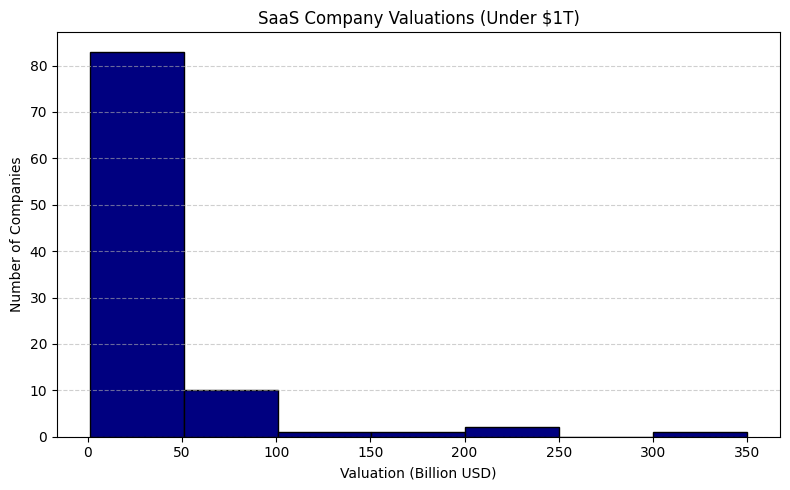

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(filtered_vals, bins=7, color='navy', edgecolor='black')
plt.xlabel("Valuation (Billion USD)")
plt.ylabel("Number of Companies")
plt.title("SaaS Company Valuations (Under $1T)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

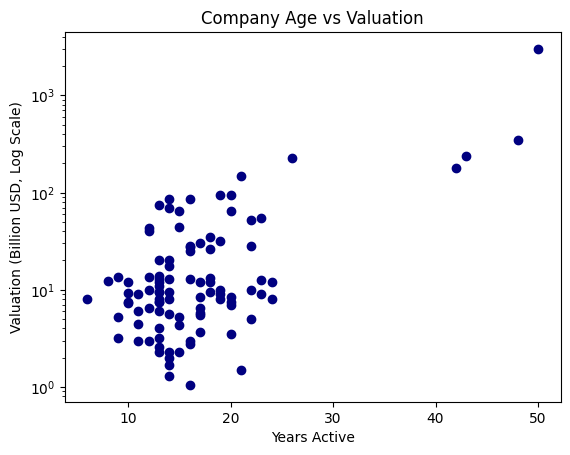

In [11]:
plt.scatter(years_active, vals_billion, color='navy')
plt.yscale('log')

plt.xlabel("Years Active")
plt.ylabel("Valuation (Billion USD, Log Scale)")
plt.title("Company Age vs Valuation")
plt.show()

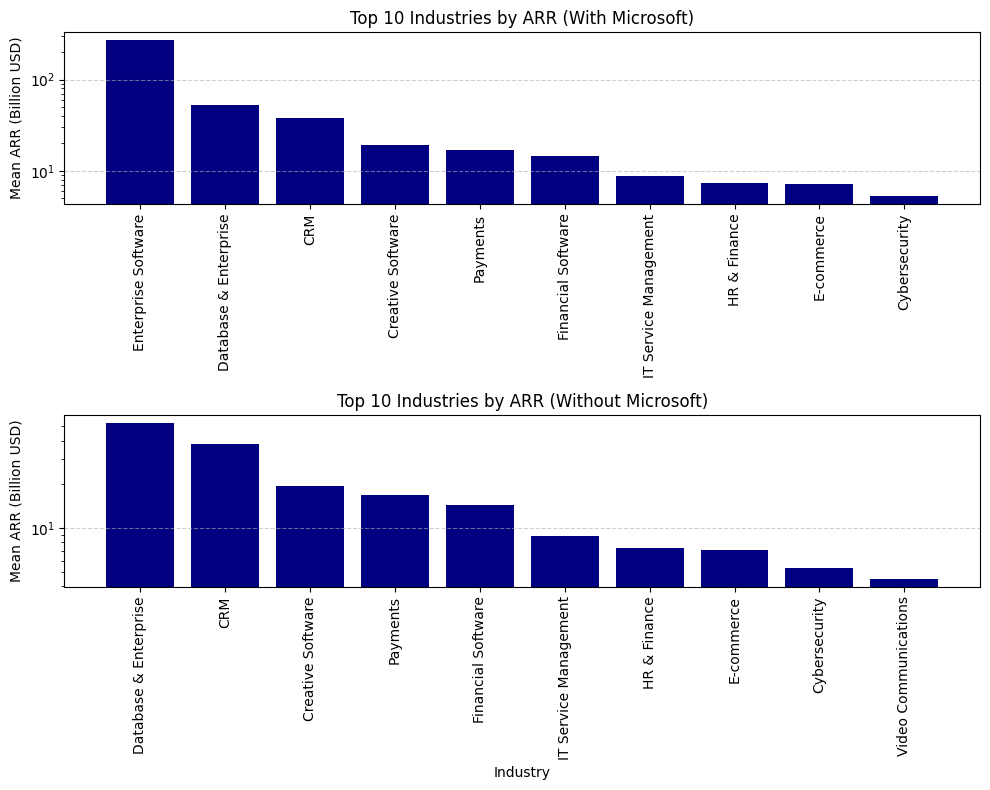

In [12]:
top_ten_arr = companies.groupby('Industry')['ARR_parsed'].mean()
top_ten_arr = top_ten_arr.sort_values(ascending= False)
top_ten_arr = top_ten_arr.head(10)


top_ten_arr_no_microsoft = companies_no_microsoft.groupby('Industry')['ARR_parsed'].mean()
top_ten_arr_no_microsoft = top_ten_arr_no_microsoft.sort_values(ascending= False)
top_ten_arr_no_microsoft = top_ten_arr_no_microsoft.head(10)


top_ten_arr = top_ten_arr/1e9 # in billions
top_ten_arr_no_microsoft = top_ten_arr_no_microsoft/1e9


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot with and without Microsoft
ax1.bar(top_ten_arr.index, top_ten_arr.values, color='navy')
ax1.set_title('Top 10 Industries by ARR (With Microsoft)')
ax1.set_ylabel('Mean ARR (Billion USD)')
ax1.set_yscale('log')
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.tick_params(axis='x', rotation=90)


ax2.bar(top_ten_arr_no_microsoft.index, top_ten_arr_no_microsoft.values, color='navy')
ax2.set_title('Top 10 Industries by ARR (Without Microsoft)')
ax2.set_xlabel('Industry')
ax2.set_ylabel('Mean ARR (Billion USD)')
ax2.set_yscale('log')
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

# Modeling

In [13]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictors = ['Employees','funding_parsed','valuation_parsed','G2 Rating','revenue_multiple','years_active']

X = companies_no_microsoft[predictors]
y = companies_no_microsoft['ARR_parsed']

In [14]:
companies_no_microsoft[predictors + ['ARR_parsed']].corr()['ARR_parsed'].sort_values(ascending=False)

ARR_parsed          1.000000
Employees           0.940561
valuation_parsed    0.918250
years_active        0.676456
funding_parsed      0.024811
revenue_multiple   -0.239742
G2 Rating          -0.292649
Name: ARR_parsed, dtype: float64

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

model = XGBRegressor(n_estimators=500, learning_rate=0.05, early_stopping_rounds = 5)
model.fit(X_train,y_train,
          eval_set=[(X_valid, y_valid)], 
          verbose=False)

predictions = model.predict(X_valid)
mae = mean_absolute_error(predictions, y_valid)
r2 = r2_score(predictions, y_valid)

print("Mean Absolute Error:" , mae)
print("R2 Score:", r2)

Mean Absolute Error: 1863285398.0
R2 Score: 0.6986716106076142


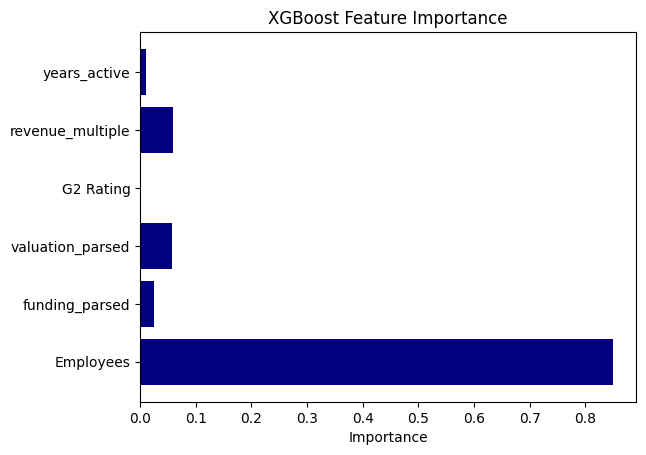

In [16]:
# Plot feature importance
xgb_importance = model.feature_importances_
plt.barh(predictors, xgb_importance, color='navy')
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.show()

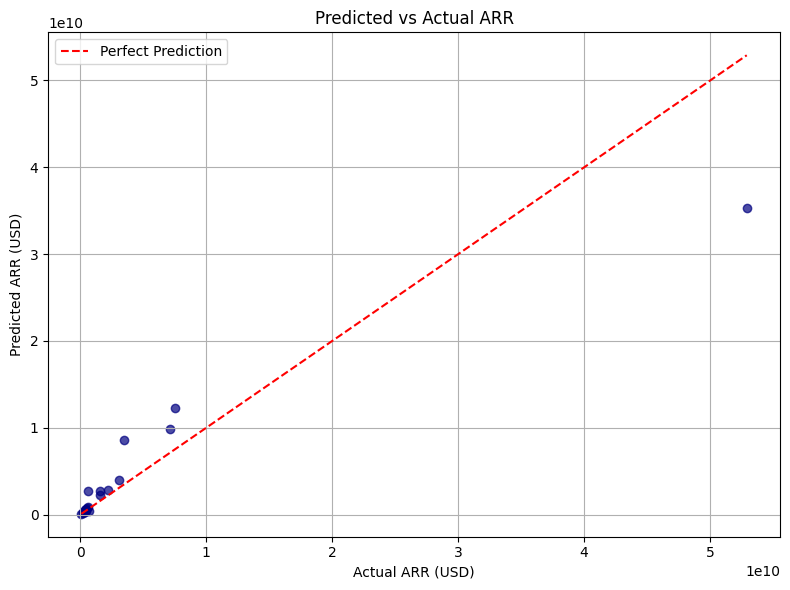

In [17]:
# Ensure y_valid and predictions are aligned
y_true = y_valid.reset_index(drop=True)
y_pred = pd.Series(predictions)

# Plot Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, color='navy')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual ARR (USD)")
plt.ylabel("Predicted ARR (USD)")
plt.title("Predicted vs Actual ARR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

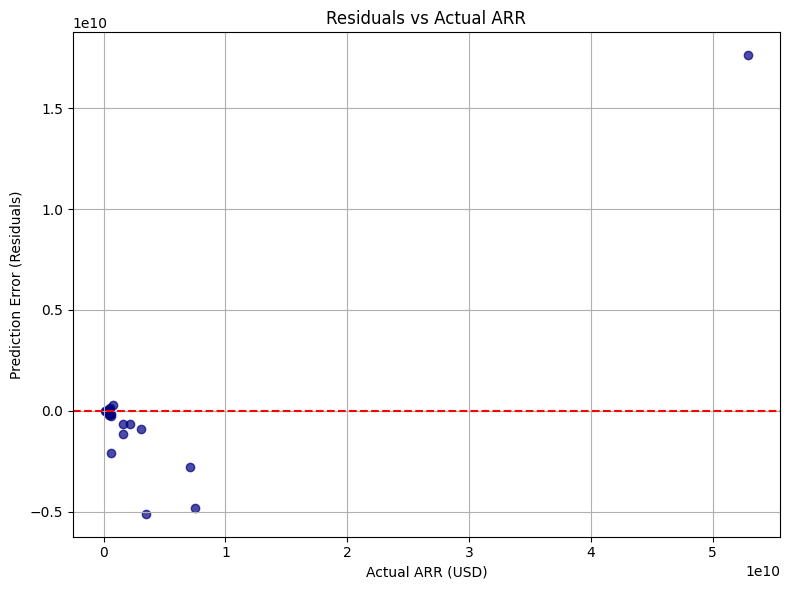

In [18]:
residuals = y_true - y_pred

# Plot: Residuals vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_true, residuals, alpha=0.7, color='navy')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual ARR (USD)")
plt.ylabel("Prediction Error (Residuals)")
plt.title("Residuals vs Actual ARR")
plt.grid(True)
plt.tight_layout()
plt.show()